### This notebook is one of my first attempts to analyze the data, so do not judge strictly, I am open to your's advices and corrections. It seems to me that I used too much code and got little results.

I personally consider those people that kill themselves as unhappy people. Let's see what is here and try to make our world better.

In [1]:
#Importing packages that we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
from scipy import stats
import seaborn as sns
%matplotlib inline

#Importing CSV file
filename = '../input/master.csv'
df = pd.read_csv(filename)
df.head(5)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


# 1. Data preparation

In [2]:
#Let's change a little bit the columns names 
df.rename(columns={' gdp_for_year ($) ': 'gdp_for_year_USD','gdp_per_capita ($)': 'gdp_per_capita_USD','country': 'Country',
                   'year': 'Year','age': 'Age','population': 'Population','suicides_no': 'Suicides_number','generation': 'Generation',
                   'suicides/100k pop' : 'Suicides/100k pop','sex': 'Sex'}, inplace=True)

# Fixing the data types
df['gdp_for_year_USD'] = df['gdp_for_year_USD'].str.replace(',', '')
df['gdp_for_year_USD'] = df['gdp_for_year_USD'].astype(int)

#Drop the column that we won't use
df = df.drop(columns=['country-year'])


In [3]:
#Let's make a copy of our main df and see the shape
df_copy = df.copy()
df_copy.shape

(27820, 11)

In [4]:
# Let's see the countries with the most unhappy people
dataset = df_copy.groupby(['Country'], as_index=False).mean()
countries = df_copy.Country.unique()
dataset = pd.DataFrame({'Country': countries,
                        'Suicides_no_mean/year':dataset['Suicides_number'],
                        'Suicides/100kpop_mean':dataset['Suicides/100k pop'],
                        'Population_number_mean':dataset['Population'], 
                        })

dataset = dataset.sort_values(by='Suicides_no_mean/year', ascending=False)
dataset['Country'] = dataset['Country'].str.replace('Republic of Korea', 'Korea')
dataset.head()

,Country,Suicides_no_mean/year,Suicides/100kpop_mean,Population_number_mean
75,Russian Federation,3733.771605,34.892377,1.139137e+07
98,United States,2779.604839,13.819812,2.165061e+07
46,Japan,2169.091398,21.573199,9.895228e+06
95,Ukraine,952.232143,26.582321,3.828777e+06
35,Germany,933.532051,15.559904,6.489986e+06


In [5]:
#Let's see how changed the suicides number in the past few years
df_top_5 = df.loc[df['Country'].isin(dataset['Country'][:5])]
df_top_5 = df_top_5.reset_index().drop(columns='index')
df_top_5 = df_top_5.groupby(['Country', 'Year'], as_index=False).sum()

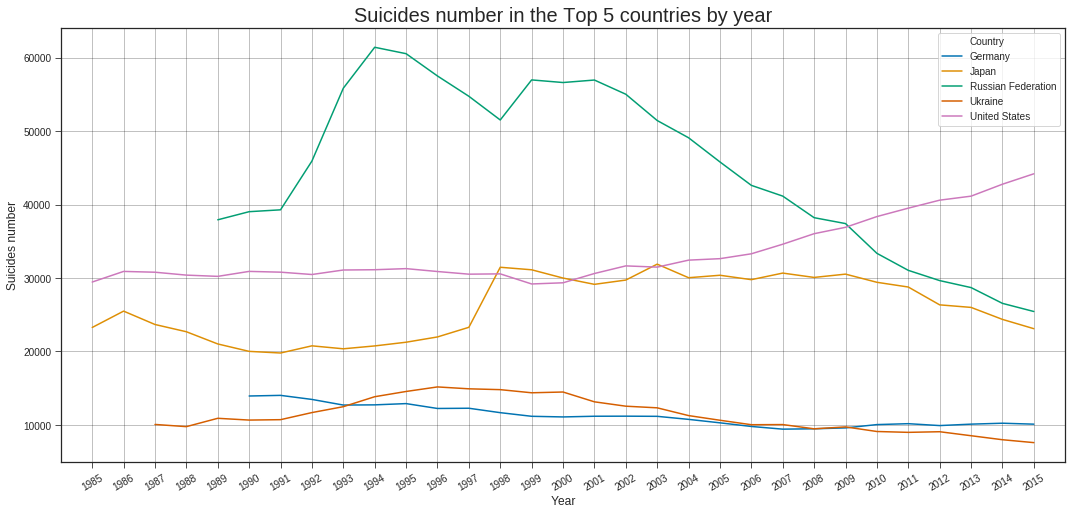

In [6]:
plt.style.use('seaborn-ticks')

fig, ax = plt.subplots(figsize=(18, 8))

ax = sns.lineplot(x='Year', y='Suicides_number', hue='Country', data=df_top_5, palette='colorblind')

plt.grid(color='k', axis='both', alpha=0.3, lw=0.8)
plt.tick_params(axis='x', labelrotation=30, length=6)
plt.legend(loc='best', fontsize='medium', frameon=True)
plt.ylabel('Suicides number', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Suicides number in the Top 5 countries by year', fontsize=20)
plt.xticks(np.arange(1985,2016))
plt.xlim(1984,2016)
plt.show()

#### Ok, Russians and Japanese really like kill themselves, but Germany and United States? So money isn't the most important component of happiness, because these 2 countries are really rich.

In [7]:
#As we see we have not enough data for all the years, so let's clean it a little bit
df_copy.groupby('Year').size().head(10)

Year
1985    576
1986    576
1987    648
1988    588
1989    624
1990    768
1991    768
1992    780
1993    780
1994    816
dtype: int64

In [8]:
 #I decided to drop the first 10 years and the last 2 while I think we will have too much uncertainty if we will fill the gap with means
df_copy = df_copy.drop(df_copy[df_copy['Year'] < 1995].index)
df_copy = df_copy.drop(df_copy[df_copy['Year'] > 2014].index)

In [9]:
#Adding the missing years  for specific countries and filling them with NaN
df_copy = df_copy.groupby(['Country','Year', 'Sex', 'Age']).sum()
mux = pd.MultiIndex.from_product(df_copy.index.levels, names=df_copy.index.names)
df_copy = df_copy.reindex(mux).reset_index()

#Creating a df with mean suicides number per year for yeach country
df_mean = df_copy.groupby(['Country', 'Sex', 'Age'], as_index=False).mean()
df_mean.Suicides_number = df_mean.Suicides_number.round().astype(int)

# Filling suicides_no NaN values with mean values
df_copy.set_index(['Country', 'Sex','Age'], inplace=True)
df_copy['Suicides_number'] = df_copy['Suicides_number'].fillna(df_mean.set_index(['Country', 'Sex', 'Age']).Suicides_number)
df_copy['Suicides/100k pop'] = df_copy['Suicides/100k pop'].fillna(df_mean.set_index(['Country', 'Sex', 'Age'])['Suicides/100k pop'])
df_copy['Population'] = df_copy['Population'].fillna(df_mean.set_index(['Country', 'Sex', 'Age']).Population)

df_copy.reset_index(inplace=True)

#Filling NaN in the others columns with values from previous year
df_copy = df_copy.fillna(method='bfill')
df_copy = df_copy.fillna(method='ffill')

# 2. Data exploration
### 2.1 Let's see what happens with the suicides number throughout the years.

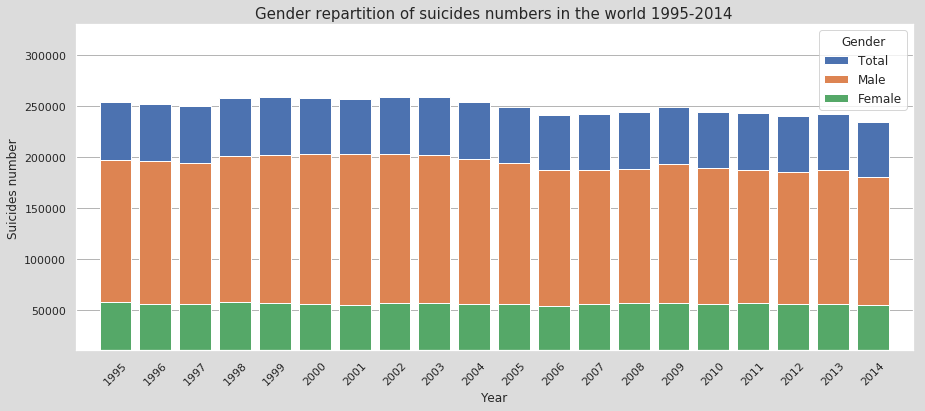

In [10]:
df_g_total = df_copy.groupby(['Year'], as_index=True).sum()
total_sn = df_g_total.iloc[:,0].to_frame()
total_sn.reset_index(inplace=True)
total_sn.head() 

df_g_male = df_copy.groupby(['Year', 'Sex'], as_index=True).sum()
total_sn_male = df_g_male.iloc[:,0].to_frame()
total_sn_male.reset_index(inplace=True)
total_sn_male = total_sn_male[total_sn_male['Sex'] == 'male']

df_g_female = df_copy.groupby(['Year', 'Sex'], as_index=True).sum()
total_sn_female = df_g_female.iloc[:,0].to_frame()
total_sn_female.reset_index(inplace=True)
total_sn_female = total_sn_female[total_sn_female['Sex'] == 'female']

sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'gainsboro'})

plt.figure(figsize=(15,6))
graph_total_sn = plt.bar(x=total_sn['Year'], height=total_sn['Suicides_number'],
                         width=0.8, label='Total')

graph_total_sn_male = plt.bar(x=total_sn_male['Year'], height=total_sn_male['Suicides_number'],
                              width=0.8, label='Male')

graph_total_sn_female = plt.bar(x=total_sn_female['Year'], height=total_sn_female['Suicides_number'],
                                width=0.8, label='Female')

plt.grid(color='k', axis='y', alpha=0.4, lw=0.8, which='both')
plt.legend(title='Gender', loc='upper right', fontsize='medium', frameon=True)
plt.tick_params(axis='x', labelrotation=45, length=6)
plt.title('Gender repartition of suicides numbers in the world 1995-2014', fontsize=15)
plt.xlabel("Year")
plt.xlim(1994,2015)
plt.xticks(total_sn['Year'])
plt.ylabel("Suicides number")
plt.ylim(10000,330000)
plt.show()

#### I see that we have 2 periods when the suicides number was especial high - the '90 and 2008-2010. Let's remember what happened in the world at this time: '90 - the collapse of the Soviet Union and the crisis in the CIS countries and 2008-2010 - the last economic crisis. We see also that women kill themseves less than mens. Why? May be because men are often responsible for the family and are especially hard on economic crises. It would be interesting to know what percentage of these men were married and how many children they had. 

### 2.2 Let's see the relationship between the suicides number, population number in the top 15 unhappiest countries.

In [11]:
dataset = dataset[:15].sort_values(by='Suicides_no_mean/year', ascending=False)
dataset.reset_index(inplace=True)

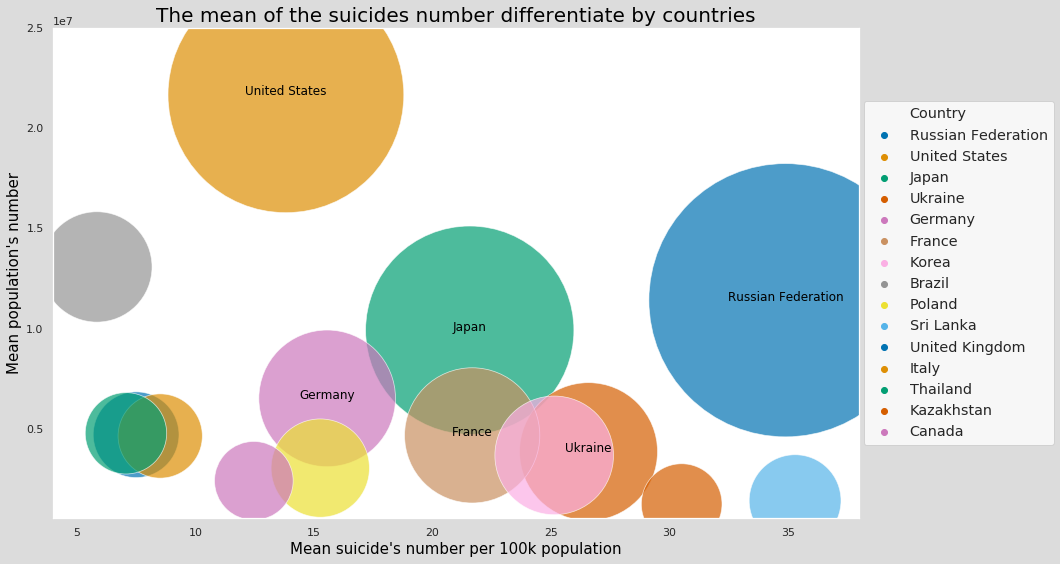

In [12]:
#Setting columns
x = 'Suicides/100kpop_mean'
y = 'Population_number_mean'
z = 'Suicides_no_mean/year'

#Creating figure
plt.figure(figsize = (15,8))
sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'lavender'})

# Create scatterplot
ax = sns.scatterplot(dataset[x], dataset[y], alpha = 0.7,
                     s = dataset[z]*20, hue='Country', 
                     data=dataset, palette='colorblind')
#For each point, we add a text inside the bubble
for line in range(0,6):
    ax.text(dataset[x][line], dataset[y][line], dataset.Country[line], 
            horizontalalignment='center', size='medium', 
            color='black', weight='normal')

plt.legend(fontsize='large', frameon=True, loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)    

ax.set_title('The mean of the suicides number differentiate by countries', fontsize=20, color='black')
ax.set_xlabel('Mean suicide\'s number per 100k population', fontsize=15, color='black')
ax.set_ylabel('Mean population\'s number', fontsize=15, color='black')

ax.set_xlim(4,38)
ax.set_ylim(500000, 25000000)
plt.tight_layout()

#### We see here that the most affected coutries are Russian Federation, Ukraine, Japan, Kazakhstan, France and Germany. Despite the fact that in the USA the population number is high, the suicide rate per 100 thousand people is low in comparison with the countries of Europe or Asia.

### 2.3 Let's see the relationship between the suicides number and age categories.

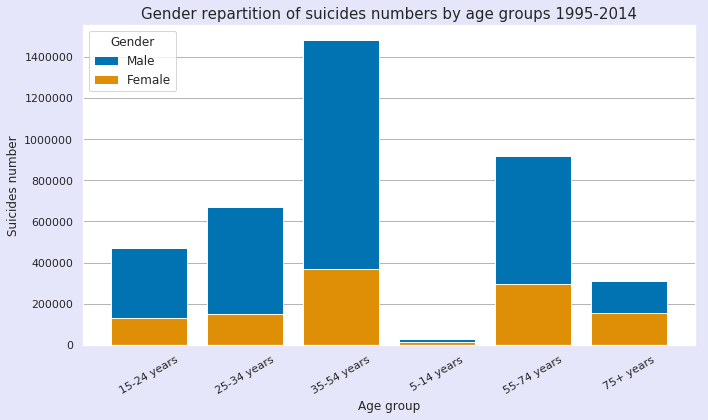

In [13]:
df_age_male = df_copy[df_copy['Sex'] == 'male'].groupby(['Age'], as_index=True).sum()
total_sn_age_male = df_age_male.iloc[:, 1].to_frame()
total_sn_age_male.reset_index(inplace=True)

df_age_female = df_copy[df_copy['Sex'] == 'female'].groupby(['Age'], as_index=True).sum()
total_sn_age_female = df_age_female.iloc[:, 1].to_frame()
total_sn_age_female.reset_index(inplace=True)

plt.figure(figsize=(10,6))
sns.set_palette('colorblind')

graph_total_sn_male = plt.bar(x=total_sn_age_male['Age'], height=total_sn_age_male['Suicides_number'],
                              width=0.8, label='Male')

graph_total_sn_female = plt.bar(x=total_sn_age_female['Age'], height=total_sn_age_female['Suicides_number'],
                                width=0.8, label='Female')

plt.grid(color='k', axis='y', alpha=0.4, lw=0.8, which='both')
plt.legend(title='Gender', loc='upper left', fontsize='medium', frameon=True)
plt.tick_params(axis='x', labelrotation=30, length=6)
plt.title('Gender repartition of suicides numbers by age groups 1995-2014', fontsize=15)
plt.xlabel("Age group")
plt.xlim()
plt.xticks(total_sn_age_male['Age'])
plt.ylabel("Suicides number")
plt.tight_layout()

####  I am surprised, I've thought that adolescents are the most supposed to suicides but I am wrong. 35 - 54 - personal middle age crisis? 55-75 - the wife or the husband is dead, I cannot live without him/her? One more time it would be interesting to know if the people in the dataset were married or not. 75+ the pain is so hard that I cannot handle more? How many people from the dataset have had a lethal disease?

### 2.3 Let's see the relationship between the suicides number and the variables in the Russian Federation.

In [14]:
df_Russia = df[df['Country'] == 'Russian Federation'].groupby(['Year', 'Sex', 'Age', 'Generation'],
                                                                        as_index=False).mean()

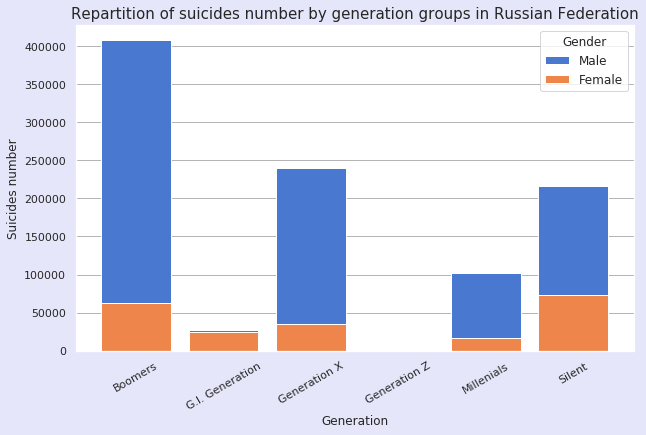

In [15]:
result = df_Russia.groupby(["Generation"])['Suicides_number'].aggregate(np.median).reset_index().sort_values('Suicides_number')

df_age_male = df_Russia[df_Russia['Sex'] == 'male'].groupby(['Generation'], as_index=True).sum()
total_sn_age_male = df_age_male.iloc[:, 1].to_frame()
total_sn_age_male.reset_index(inplace=True)

df_age_female = df_Russia[df_Russia['Sex'] == 'female'].groupby(['Generation'], as_index=True).sum()
total_sn_age_female = df_age_female.iloc[:, 1].to_frame()
total_sn_age_female.reset_index(inplace=True)

plt.figure(figsize=(10,6))
sns.set_palette('muted')

graph_total_sn_male = plt.bar(x=total_sn_age_male['Generation'], height=total_sn_age_male['Suicides_number'],
                              width=0.8, label='Male', align='center')

graph_total_sn_female = plt.bar(x=total_sn_age_female['Generation'], height=total_sn_age_female['Suicides_number'],
                                width=0.8, label='Female', align='center')

plt.grid(color='k', axis='y', alpha=0.4, lw=0.8, which='both')
plt.legend(title='Gender', loc='best', fontsize='medium', frameon=True)
plt.tick_params(axis='x', labelrotation=30, length=6)
plt.title('Repartition of suicides number by generation groups in Russian Federation', fontsize=15)
plt.xlabel("Generation")
plt.xticks(total_sn_age_male['Generation'])
plt.ylabel("Suicides number")
plt.show()

#### Poor Boomers the have seen so many changes in this World

In [16]:
#Changing data from cathegorical to numerical
def age_to_numeric(x):
    if x=='5-14 years':
        return 0
    if x=='75+ years':
        return 1
    if x=='15-24 years':
        return 2
    if x=='25-34 years':
        return 3
    if x=='55-74 years':
        return 4
    if x=='35-54 years':
        return 5

def generation_to_numeric(x):
    if x=='Generation Z':
        return 0
    if x=='G.I. Generation':
        return 1
    if x=='Millenials':
        return 2
    if x=='Silent':
        return 3
    if x=='Generation X':
        return 4
    if x=='Boomers':
        return 5

def sex_to_numeric(x):
    if x=='male':
        return 1
    if x=='female':
        return 0
    
df_Russia['Age'] = df_Russia['Age'].apply(age_to_numeric)
df_Russia['Sex'] = df_Russia['Sex'].apply(sex_to_numeric)
df_Russia['Generation'] = df_Russia['Generation'].apply(generation_to_numeric)

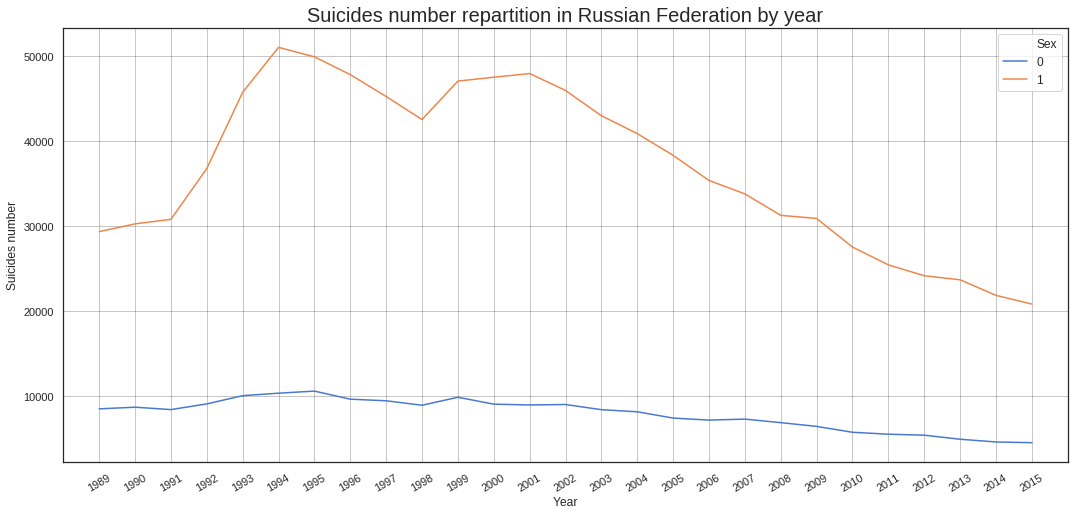

In [17]:
table = df_Russia.groupby(['Year', 'Sex'], as_index = False).sum()


plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(figsize=(18, 8))

ax = sns.lineplot(x='Year', y='Suicides_number', hue='Sex', data=table)

plt.grid(color='k', axis='both', alpha=0.3, lw=0.8)
plt.tick_params(axis='x', labelrotation=30, length=6)
plt.legend(loc='best', fontsize='medium', frameon=True)
plt.ylabel('Suicides number', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Suicides number repartition in Russian Federation by year', fontsize=20)
plt.xticks(np.arange(1989,2016))
plt.xlim(1988,2016)
plt.show()

#### In the last 10 year Russians are trying not to kill themselves so much. Why? A better life quality? Unfortunately, we have-not enough HDI data for these researches.

#### Let's see the relationship GDP, Generation vs Suicides number

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


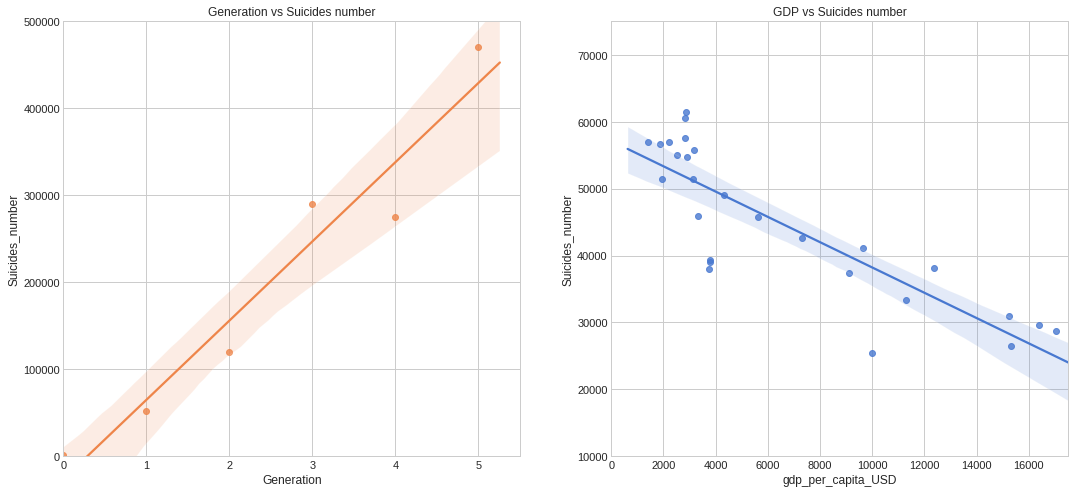

In [18]:
plt.style.use('seaborn-whitegrid')
df_gdp = df_Russia.groupby('gdp_per_capita_USD', as_index = False).sum()
df_generation = df_Russia.groupby('Generation', as_index = False).sum()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.regplot(ax=ax[1], x='gdp_per_capita_USD', y='Suicides_number', data=df_gdp)
sns.regplot(ax=ax[0], x='Generation', y='Suicides_number', data=df_generation)

ax[1].set_title('GDP vs Suicides number')
ax[0].set_title('Generation vs Suicides number')
ax[0].set_xlim(0, 5.5)
ax[0].set_ylim(0, 500000)
ax[1].set_xlim(0, 17500)
ax[1].set_ylim(10000, 75000)
plt.show()

We see I a clear relationship between generations group and suicides number and I am very happy that the Z generation (1995-2010) doesn't like to kill herself. There is also a correlation between GDP and suicide rates. We see that the higher the GDP, the less the suicides number.    

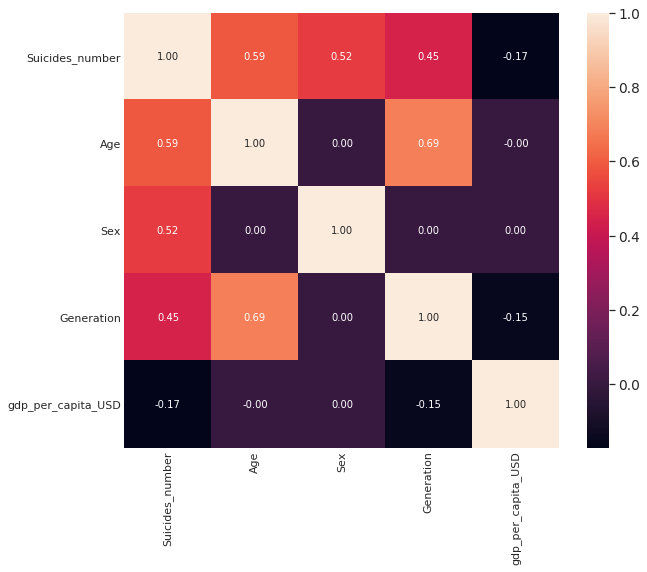

In [19]:
#And finally a heatmap
corrmat = df_Russia[['Sex', 'Age', 'Suicides_number', 'gdp_per_capita_USD', 'Generation']].corr()
k = 10
f, ax = plt.subplots(figsize=(10, 8))
cols = corrmat.nlargest(k, 'Suicides_number')['Suicides_number'].index
#cols = ['sex', 'age', 'generation', 'gdp_per_capita_USD']
cm = np.corrcoef(df_Russia[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(
    cm, 
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 10},
    yticklabels=cols.values,
    xticklabels=cols.values)
plt.show()

#### The relationship between variables and suicides number isn't very strong, but it exists.

# 3. Conclusions

### 1. People protect men they are endangered species! Men are more susceptible to suicide than women, so they need psychological support and therefore governments should take this into account when developing educational plans.
### 2. Be careful! don't be born in Russia! The most affected countries are located in Europe and East Europe, but while in these countries the number of suicides has been falling in the last couple of years, it is growing rapidly in the USA and they really should do something. (the Japanese will always have a reason to kill themselves so that they do not count)
### 3. The goverment shoud pay atention to the people between 34-55 years, there are very likely to kill themseves. Perhaps regular medical assistance provided by a psychologist can help these people.
### 4. If we want people to kill themselves less often we need a stable economy and a high level of GDP.